# Applied Data Science Capstone: most similar neighbourhood in another city
*by Eduardo M. de Morais*


# 1. Introduction

It is very common for people to have to move to another city. The reasons for this are quite diverse and can involve professional opportunities, personal reasons, among others. This process can be quite difficult for some people, as it involves adapting to a new and possibly different environment. Although two cities may be completely different, they may have neighborhoods with similar characteristics in common. Knowledge of this information can be crucial when choosing a new place to live in a new city. Thus, a person can choose to move to a neighborhood in a new city with similar characteristics to the neighborhood in the city where he lives and is already acclimated.

For this project, I choose to work with cities in Brazil, the country where I live. We have two of the largest cities in the world with very distinct characteristics: São Paulo and Rio de Janeiro. Locally, each of this places acts like professional centers attracting professionals and companies. Sometimes, a company in one of this cities is interesting in a professional that lives in the other city. Certainly, if the professional find a similiar  neighbourhood, he will be more likely to accept an offer if it is professionally interesting.

Suppose I live in São Paulo, in the Barra Funda neighborhood, and have been offered a job to work in Rio de Janeiro. What would be the neighborhood most similar to Barra Funda in Rio de Janeiro?


# 2. Data

**A** To complete our task, we will need to use some datasets for the analysis approach. First, we need to obtain a data source for the neighborhoods in each of the cities. This can be found on the website `www.guimais.com.br`:
   - (São Paulo): https://www.guiamais.com.br/bairros/sao-paulo-sp
   - (Rio de Janeiro): https://www.guiamais.com.br/bairros/rio-de-janeiro-rj
   
**B** The next step is obtain the coordinates for each neighbourhood. It can be done using the Nominatim tool, from OpenStreetMap

**C** With the neighbourhoods and its coordinates we can use de Foursquare API to get the venues in each neighbourhood.

# 3. Methodology

I have to follow the next steps to solve the problem:
1. Scrap the neighbourhood data from the `guiamais.com.br` using BeautifulSoup package.
2. Gets Coordinates for each Neighbourhood using **nominatim**
3. Gets the venues in each neighbourhood within a radius of 5km using **Foursquare** API. This is a good value because places at that distance can be accessed quickly by car. 
4. Count the most common categories of venues. I will consider only the categories that appears more than 100 times. After this, I  will create a feature for each of this categories checking if the number of times that it appears in each neighbourhood is more than 3. If yes, returns a 1 and 0 if no.
5. Cluster the data using KMeans, choosing a number of clusters from 3 to 8 and choose the best using a score the maximize Silhouette score, Calinski-Harabasz score and minimizes the Davies-Bouldin score.

## 3.1 Importing packages

In [1]:
import pandas as pd
import numpy as np
import re
import requests 
import folium
import pickle
import random
from bs4 import BeautifulSoup
from html import unescape
from tqdm import tqdm
from geopy.geocoders import Nominatim
from functools import reduce
from collections import Counter 

Here, I define the properties of each city and save it in a dictionary:

In [2]:
# Define here the cities and its respectives urls to
# scrap the neighbourhood list
cities = {
    'rj': {
        'name': 'Rio de Janeiro',
        'url':'https://www.guiamais.com.br/bairros/rio-de-janeiro-rj',
        'long_min': -43.694087,
        'long_max': -43.166904,
        'lat_min': -23.047039,
        'lat_max': -22.785521,
    },
    'sp':{
        'name': 'São Paulo',
        'url':'https://www.guiamais.com.br/bairros/sao-paulo-sp',
        'long_min': -46.860478,
        'long_max': -46.137922,
        'lat_min': -23.850532,
        'lat_max': -23.385265,
    }
}

## 3.2 Importing Dataset

The first step is scrap the dataset of neighbourhood information from `guiamais.com.br`. Since we have to do this more than one time, lets define a function for this. To scrap the neighbournames, we just need the url: 

### 3.2.1 Scrap Neighbourhood Information

In [3]:
def scrap_neighbourhoods_from_guiamais(url):
    """Scraps the neighbourhoods list of a city from
    a given url of guiamais.com.br site.
    """

    table = BeautifulSoup(requests.get(url).text, "lxml").find(
        "section", class_="cities centerContent"
    )

    table_string = unescape(str(table.find_all("li")))

    return re.findall('">(.*?)</a', table_string)


Now, we have to scrap the date through the cities and concatenate the information:

In [4]:
def neighbourhood_dataframe(city, neighbourhood_list):
    """ Trasform a list of neighbourhood into dataframe  """
    return pd.DataFrame(
        [(city, nb) for nb in neighbourhood_list], columns=["city", "neighbourhood"]
    )


# Scrapes neighbourhood and creates a pandas dataframe with the result
df = pd.concat(
    [
        neighbourhood_dataframe(
                cities[_]['name'],
                scrap_neighbourhoods_from_guiamais(cities[_]['url'])    
        )  for _ in cities
    ]
).reset_index(drop=True)

Printing a data sample

In [5]:
print('\n\nSample of data:')
pd.concat(
    [
        df.loc[df['city']=='Rio de Janeiro'].sample(2),
        df.loc[df['city']=='São Paulo'].sample(2),
    ]
)



Sample of data:


,city,neighbourhood
75,Rio de Janeiro,Humaitá
162,Rio de Janeiro,Tomás Coelho
1884,São Paulo,Vila Siqueira
726,São Paulo,Jardim Itapemirim


### 3.2.2 Gets Coordinates for each Neighbourhood

For each neighbourhood, I will call the nominatim to import the coordinates.

In [6]:
def get_neighbourhood_coord(nominatim, city, neighbourhood):
    """ Gets the coordinate of a neighbourhood """
    
    try:
        location = nominatim.geocode(neighbourhood + " - " + city + ", Brazil")
        return (location.latitude, location.longitude)

    except Exception as inst:
        return (None, None)


As we are working with a large number of neighbourhoods, it is convenient to save the results in a csv file.

In [7]:
if False:
    # instantiate the Nominatim class
    geoloc = Nominatim(user_agent="test_app")

    # Gets the coordinates of all neighbourhoods
    coord_list = [
        get_neighbourhood_coord(geoloc,row['city'],row['neighbourhood']) 
         for index, row in tqdm(df.iterrows(),total = len(df))
    ]

    # Adds the coordinates to neighbourhoods dataframe
    df = pd.concat(
        [
            df,
            pd.DataFrame(coord_list,
                columns=['latitude','longitude'])
        ],
        axis=1
    )

    # Exports the result
    df.to_csv(
        'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv',
        index=False
    )

In [8]:
# Import the dataframe of neighbourhood
df = pd.read_csv( 'data/coord'+reduce(lambda x,y: '_'+x+'_'+y,[_ for _ in cities])+'.csv')

# create a neighbourhood index
df = df.reset_index()

# Remove all neighbourhoods without coordinates
df = df.dropna()

df.drop(index=df[(df['neighbourhood']=='Campos Elíseos') & (df['city']=='São Paulo')].index[0],inplace=True)

### 3.2.3 Gets the venues for each neighbourhood with Foursquare

The first step is define the credentials. I have it in a separated csv file that I will import here:

In [9]:
CLIENT_ID,CLIENT_SECRET,ACCESS_TOKEN,VERSION = \
    pd.read_csv('data/credentials.csv').T.to_dict()[0].values()

The approach here is use the explore query from Foursquare, passing the coordinates for each neighbourhood and get the venues. Here, I will set a radius of 1.5 km and limit the search in 1000 venues. If the Foursquare do not find any venue, so the fucntion will return an empty dict.

In [10]:
def get_nearby_venues(index,
                      city,
                      neighbourhood,
                      latitude,
                      longitude,
                      radius = 1500,
                      limit = 1000):
    """ Query to explore the neighbourhood places in foursquare api """
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)

    try:
        return {
            'index': index,
            'city': city,
            'neighbourhood': neighbourhood,
            'result': requests.get(url, timeout=5).json()["response"]['groups'][0]['items']
        }
    except:
        return {
            'index': index,
            'city': city,
            'neighbourhood': neighbourhood,
            'result': None
        }

Here, I'll print an example of output

In [11]:
results = get_nearby_venues(
    df.iloc[60]['index'],
    df.iloc[60]['city'],
    df.iloc[60]['neighbourhood'],
    df.iloc[60]['latitude'],
    df.iloc[60]['longitude'],
    radius = 5000,
    limit = 1000
)
results

{'index': 72,
 'city': 'Rio de Janeiro',
 'neighbourhood': 'Guaratiba',
 'result': None}

Since it is not a fast procedure, I'll save the results in a pickle file to import whenever I need.

In [12]:
if False:
    
    # Gets the venues for all neighbourhoods
    foursquare_result = [
        get_nearby_venues(
            row['index'],
            row['city'],
            row['neighbourhood'],
            row['latitude'],
            row['longitude'],
            radius = 5000,
            limit = 2000
        )

        for index, row in tqdm(df.iterrows(),total = len(df))
    ]

    pickle.dump(foursquare_result, open("data/foursquare_result.p", "wb" ))
    
foursquare_result = pickle.load(open("data/foursquare_result.p","rb" ))

Now, we have a list of venues. Lets format to put it in a pandas dataframe:

In [444]:
def format_category(category_list):
    return '|'.join(
        [
            cat.get('name','').replace(' / ','|')\
                .replace(' | ','|').replace(' & ','|')\
                    .replace(' ','_')#.replace('_','|')
            for cat in category_list
        ]
    )

# Loop through the venues
list_venues = []

for nb_venues in foursquare_result:
    for result in (nb_venues['result'] or []):
        if result:
            list_venues.append(
                {
                    'id': result['venue']['id'],
                    'nb_index': nb_venues['index'],
                    'name': result['venue']['name'],
                    'categories': format_category(
                        result['venue'].get('categories',[])),
                    'distance': result['venue']['location']['distance'],
                }
            )
        
df_venues = pd.DataFrame(list_venues)

max_distance = 5000

df_venues = df_venues[df_venues['distance']<=max_distance]


df_venues.sample(3)

,id,nb_index,name,categories,distance
8435,4c027029f56c2d7f01611b66,101,Estação do Pão,Bakery,4350
12833,4c82fcbfd4e23704b5586d88,155,Corruptos S.A. Bar,Bar,3490
34102,4f5402b5e4b02cf6bf95c8dd,578,Praça do Jardim Myrna (Perto do Levi),Park,4300


## 3.3 Pre-Processing

Now, we have to group by neighbourhood and concatenate the categories

In [445]:
def concat_categories(series):
       return reduce(lambda x, y: x +'|'+y, series)

df_venues_nb = df_venues.groupby('nb_index').agg({'categories':  concat_categories})

df_venues_nb.sample(3)

,categories
nb_index,
611,Coffee_Shop|Pizza_Place|General_Entertainment|...
1353,Pizza_Place|Snack_Place|Coffee_Shop|Pool|Ice_C...
221,Brazilian_Restaurant|Dessert_Shop|Bakery|Asian...


With a table relating neighbourhoods and categories, lets make a inner join with the neighbourhood table

In [446]:
df_categories = df.merge(
    df_venues_nb,
    left_on = 'index',
    right_index = True,
    how='inner'
).rename(columns={'index':'neighbourhood_id'}).set_index('neighbourhood_id')



df_categories.sample(3)


,city,neighbourhood,latitude,longitude,categories
neighbourhood_id,,,,,
873,São Paulo,Jardim Nova Conquista,-22.727747,-47.382621,Gym|Food_Truck|Dance_Studio|Food_Truck|Burger_...
395,São Paulo,Horto,-20.575001,-47.863817,Candy_Store|Gym|Bar|Gym|Fitness_Center|Brazili...
981,São Paulo,Jardim Roseli,-23.598059,-46.436347,Dessert_Shop|Bakery|Flower_Shop|Martial_Arts_S...


### 3.3.1 Counting Categories

Lets select just the venue categories that appear more than 100 times.

In [447]:
def n_most_common_words(categories,n=None,n_min = 1):
    
    words_list = '|'.join(categories)

    for char in ['/','&']:
        words_list = words_list.replace(char,'')
    
    result = Counter(words_list.split('|'))
    
    if n:
        result =  dict(result.most_common(n))
    
    else:
        result =  dict(result.most_common())
        
    return dict((filter(lambda x: x[1]>=n_min,result.items())))

most_common_words = n_most_common_words(df_venues['categories'],n_min = 1)
# most_common_words

### 3.5 Creating dummies for categories

In [506]:

df_cluster = df_categories.copy()

# Creates columns for categories 
for word in most_common_words:
    df_cluster[word] = df_cluster['categories'].apply(lambda x: x.count(word))
    
df_cluster.iloc[:,5:] = df_cluster.iloc[:,5:].applymap(lambda x: 3 if x > 0 else 0 )

# df_cluster['total'] = df_cluster.iloc[:,5:].sum(axis=1)

# df_cluster.iloc[:,5:] = df_cluster.iloc[:,5:].apply(
#     lambda row: row/row['total'] if row['total']>0 else row ,axis=1 )

# df_cluster.drop(columns='total',inplace=True)

In [507]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

scaler = MinMaxScaler()


try:
    df_cluster.drop(columns = ['labels','color'],inplace=True)
except:
    pass


for cat in ['Restaurant','Bakery','Gym','Food','Shop','Pizza_Place','Bar','Brazilian_Restaurant']:
    try:
        df_cluster.drop(columns=cat,inplace=True)
    except:
        pass



data = df_cluster.iloc[:,5:]
data = scaler.fit_transform(data)


results = {
    'labels': [],
    'param':[],
    'n_labels':[],
    'davies_bouldin_score':[],
    'silhouette_score':[],
    'calinski_harabasz_score':[],
    'comb_score':[],
}


for par in range(3,8,1):
# for par in np.arange(0.5,2.5,0.1):
    clustering = KMeans(n_clusters=par,algorithm='elkan',random_state=42).fit(data)
#     clustering = DBSCAN(eps = par,min_samples = 5).fit(data)
    labels = clustering.labels_
    results['param'].append(par)
    results['labels'].append(labels)
    results['n_labels'].append(len(np.unique(labels)))
    results['davies_bouldin_score'].append(davies_bouldin_score(data,labels))
    results['silhouette_score'].append(silhouette_score(data,labels))
    results['calinski_harabasz_score'].append(calinski_harabasz_score(data,labels))
    results['comb_score'].append(
        (calinski_harabasz_score(data,labels) * silhouette_score(data,labels) ) /(davies_bouldin_score(data,labels))
    )
    
    
    
df_res = pd.DataFrame(results)


best_comb_score = df_res['comb_score'].max()

df_cluster['labels'] = df_res[df_res['comb_score'] == best_comb_score]['labels'].to_list()[0]
# df_cluster['labels'] = labels

colors_list = ['#000000','#3f95d0','#ff0114','#dbb027','#045c5c','#ffa300',]+\
                ['#'+format(random.randint(0,16777215),'x') for i in range(20)]

df_cluster['color'] = df_cluster['labels'].apply(lambda x: colors_list[x])

In [508]:
df_gr = df_cluster.iloc[:,5:-1].groupby('labels').mean()

resut = []
for lab in df_gr.index:
    list_ven = df_gr.iloc[lab].sort_values(ascending=False)
    list_ind = list_ven.index
    dict_res = {'label': lab}

    for i in range(len(list_ven)): dict_res.update({'word_'+str(i): list_ind[i]})

    resut.append(dict_res)
df_words = pd.DataFrame(resut).T.head(20).iloc[1:]

## Common Words

Here, we have the categories common to all groups:

In [509]:
col = 0

# words common to all columns
common = set(df_words[0])
for i in range(1,df_words.shape[1]):
    common = common.intersection(set(df_words[i]))
    
common

{'Burger_Joint',
 'Fitness_Center',
 'Ice_Cream_Shop',
 'Japanese_Restaurant',
 'Park'}

In [510]:

pd.DataFrame(
    dict(
        [
            (i,tuple(filter(lambda x: x not in common, df_words[i]))) 
            for i in range(df_words.shape[1])
        ]
    )
)

,0,1,2,3,4,5,6
0,Food_Truck,Hotel,Dessert_Shop,Coffee_Shop,Steakhouse,Dessert_Shop,Coffee_Shop
1,Fast_Food_Restaurant,Snack_Place,Coffee_Shop,Italian_Restaurant,Market,Market,School
2,BBQ_Joint,Supermarket,Arts,Steakhouse,Dessert_Shop,Fast_Food_Restaurant,Chocolate_Shop
3,Plaza,Grocery_Store,Steakhouse,Hotel,Italian_Restaurant,Snack_Place,Soccer_Stadium
4,Steakhouse,Market,Pharmacy,Theater,Pet_Store,Supermarket,Pastry_Shop
5,Snack_Place,Plaza,School,Plaza,Supermarket,Food_Truck,Stadium
6,School,BBQ_Joint,Market,Café,Gymnastics_Gym,Pharmacy,Samba_School
7,Sports,Café,BBQ_Joint,Bookstore,Farm,Café,Café
8,Athletics,Pharmacy,Supermarket,Vegetable_Store,Farmers_Market,Sandwich_Place,Seafood_Restaurant
9,Samba_School,Sandwich_Place,Pet_Store,Fruit,Café,Grocery_Store,Fried_Chicken_Joint


In [511]:
common = set(df_words[0])

for i in range(1,df_words.shape[1]):
    common = common.intersection(set(df_words[i]))

not_common=[]    
for i in range(df_words.shape[1]):
    list_ = []
    for j in range(df_words.shape[1]):
        if i != j:
            list_.append((i,j,list(set(df_words[i])-set(df_words[j]))))
        not_common.append(list_)



# base_ = not_common[2][0][2]
# for i in range(1,df_words.shape[1]-1):
#     list_ = not_common[2][i][2]
    
#     base_ = list(set(base_)-set(list_))

    
# base_
# # not_common

In [512]:
# set(df_words[0]).difference(set(df_words[1])).difference(set(df_words[2]))

In [513]:
# set(df_words[1]).difference(set(df_words[0])).difference(set(df_words[2]))#.difference(set(df_words[3]))

In [514]:
# set(df_words[2]).difference(set(df_words[0])).difference(set(df_words[1]))#.difference(set(df_words[3]))

In [515]:
# set(df_words[3]).difference(set(df_words[0])).difference(set(df_words[1])).difference(set(df_words[2]))

## São Paulo

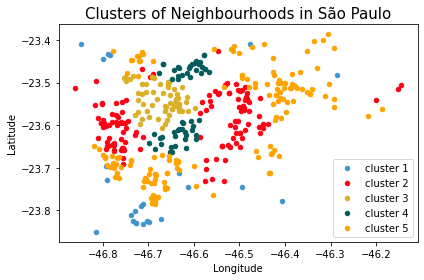

In [516]:
import matplotlib.pyplot as plt
import numpy as np

city = cities['sp']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]

for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods in '+city['name'], fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood-sp.png')
plt.show()

In [517]:
import random
from IPython.core.display import display, HTML

city = cities['sp']


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

## Rio de Janeiro

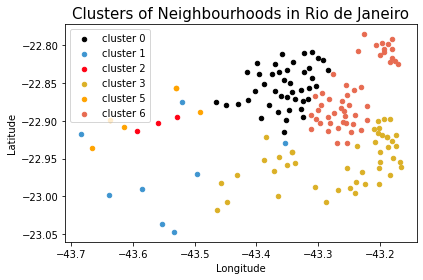

In [518]:
city = cities['rj']

conditions = df_cluster['city'] == city['name']
conditions &= (df_cluster['latitude'] > city['lat_min']) & (df_cluster['latitude'] < city['lat_max'])
conditions &= (df_cluster['longitude'] > city['long_min']) & (df_cluster['longitude'] < city['long_max'])
df_cat = df_cluster[conditions]

for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods in '+city['name'], fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood-rj.png')
plt.show()

In [519]:
import random
from IPython.core.display import display, HTML


geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(city['name'])
latitude = location.latitude
longitude = location.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto

# Results

# Discussion

# Conclusion

In [1]:
import numpy as np
import pandas as pd
import requests


Using `pandas.read_html` to get a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name

In [2]:
df_codes = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Only process the cells that have an assigned borough.
# Ignore cells with a borough that is Not assigned.
df_codes = df_codes[df_codes['Borough'] != 'Not assigned'].reset_index(drop=True)

# If a cell has a borough but a Not assigned  neighborhood,
# then the neighborhood will be the same as the borough.
df_codes['Neighbourhood'] = df_codes.apply(
    lambda x: x['Neighbourhood'] if x['Neighbourhood']!='Not assigned' else x['Borough'],axis=1)

# In order to utilize the Foursquare location data, we need
# to get the latitude and the longitude coordinates of each
# neighborhood.
df_geospatial = pd.read_csv('https://cocl.us/Geospatial_data')

# Joining datasets
df = df_codes.merge(df_geospatial,on="Postal Code",how="left")

In [3]:
df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 

Insert credentials

In [5]:
CLIENT_ID = 'BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG' # your Foursquare ID
CLIENT_SECRET = '3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF' # your Foursquare Secret
ACCESS_TOKEN = '3DAFXVUZH2QSV4ARG42A5EATNKI1PODQNMAKUZMI31XZWE25' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BELQR33E4XOD32YRUYPSXUVVVR3GTWECQU2TXT1IT2CS10DG
CLIENT_SECRET:3CCUNF3DMCFDUTCTIBLUYA0JWVXANW2EQ0R0GV4L5X2UKDFF


Define a function to query the venues for each neighbourhood

In [208]:
def get_nearby_venues(
    postal_code,
    borough,
    neighbourhood,
    latitude,
    longitude,
    radius = 500,
    limit = 100):
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        limit)

    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    return [{
        'postal_code': postal_code,
        'borough':borough,
        'neighbourhood':neighbourhood,
        'latitude': latitude,
        'longitude': longitude,
        'name': result['venue']['name'],
        'categories': [cat['name'] for cat in result['venue']['categories']],
#         'categories_full': result['venue']['categories']
        
    } for result in results]

Applying the `get_nearby_venues` to neighbourhoods 

In [210]:
from tqdm import tqdm

list_venues = []

# Get venues for each neighbourhood
for index, row in tqdm(df.iterrows(),total = len(df)):
    results = get_nearby_venues(
        str(row['Postal Code']), 
        str(row['Borough']), 
        str(row['Neighbourhood']), 
        row['Latitude'],
        row['Longitude'],
    )
    
    categories = []
    for result in results:
        categories += result['categories']
    
    list_venues.append({
        'postal_code': str(row['Postal Code']),
        'borough': str(row['Borough']),
        'neighbourhood': str(row['Neighbourhood']),
        'latitude': row['Latitude'],
        'longitude': row['Longitude'],
        'categories': pd.Series(categories,name = 'categories').value_counts().to_dict()
    })

100%|██████████| 103/103 [01:20<00:00,  1.28it/s]


Here, I want to write a function to get all possible categories

In [211]:
from functools import reduce
def get_category_values(venues):
    result = list(
        set(
            reduce(
                lambda x,y : x + y,
                [
                    list(venue['categories'].keys()) for venue in venues
                ]
            )
        )
    )
    
    result.sort()
    
    return result
    
category_values = get_category_values(list_venues)

With the categories, It is possible to get the most frequent words on neighbourhood venues

In [509]:
from collections import Counter 

def n_most_common_words(n,venues=list_venues):
        
    list_str = []
    
    for venue in venues:
        try:
            list_str.append(
                reduce(
                    lambda x,y: x+' '+y+' ',
                    [(key+' ')*value for key, value in venue['categories'].items()]
                )
            )

        except:
            pass


    concat_categories = reduce(lambda x,y: x+' '+y+' ',list_str)

    for char in ['/','&']:
        concat_categories = concat_categories.replace(char,'')

    return dict(Counter(concat_categories.split()).most_common(n))

most_common_words = n_most_common_words(250)


Count the words in venues of each neighbourhood

In [510]:
def get_venue_feature_array(venue):

    result = {
        'postal_code': str(venue['postal_code']),
        'borough': str(venue['borough']),
        'neighbourhood': str(venue['neighbourhood']),
        'latitude': venue['latitude'],
        'longitude': venue['longitude'],
    }
    
    result.update(dict([(key,0) for key in most_common_words.keys()]))

    for key, value in venue['categories'].items():
        for word in key.split():
            if word in result.keys(): result[word] += value
                
    return result

venues_array = [get_venue_feature_array(venue) for venue in list_venues]
df_cat = pd.DataFrame(venues_array)

df_cat.head()


,postal_code,borough,neighbourhood,latitude,longitude,Restaurant,Shop,Store,Coffee,Place,Bar,Café,Food,Pizza,Park,Gym,Bakery,Italian,Hotel,Sandwich,American,Japanese,Clothing,Joint,Fast,Grocery,Sushi,Bank,Pub,Beer,Pharmacy,Theater,Breakfast,Spot,Seafood,Thai,Market,Gastropub,Center,Diner,Tea,Vegetarian,Vegan,Art,Studio,Deli,Bodega,Intersection,Fried,Chicken,Eastern,Bookstore,Station,Cocktail,Gallery,Mexican,Burrito,Sporting,Goods,Ice,Steakhouse,Liquor,Asian,Yoga,Dessert,Home,Chinese,Cream,Burger,Juice,Convenience,Greek,Brewery,Indian,Furniture,Middle,Lounge,Salad,Arts,Farmers,Fitness,Wine,Cosmetics,Department,Discount,Airport,Venue,French,Vietnamese,Salon,Museum,Court,Electronics,Bubble,Movie,Shopping,Mall,Pet,Service,Spa,Creperie,Caribbean,New,Room,Supermarket,Barbershop,Fish,Stadium,Concert,Hall,Gift,Ramen,Plaza,Bus,Comfort,Club,College,General,Music,Sports,European,Game,Jazz,Playground,Field,Cheese,Mediterranean,Latin,Baseball,Garden,Pool,Crafts,Skating,Rink,Irish,Tailor,Truck,Trail,Basketball,Gourmet,Gas,Jewelry,Men's,Aquarium,Line,Drink,Portuguese,Performing,Distribution,Space,Miscellaneous,Boutique,Entertainment,Smoothie,Athletics,Lingerie,Smoke,Video,Bistro,Fountain,Neighborhood,Nightclub,Bagel,Korean,Business,Poke,Mobile,Phone,Speakeasy,House,Gluten-free,Gay,Light,Rail,Antique,Event,Comic,Modern,Office,Construction,Landscaping,BBQ,Rental,Car,Location,Health,Chips,Falafel,Dog,Run,Noodle,Toy,Scenic,Lookout,History,Monument,Landmark,Train,Hockey,Arena,Chocolate,Shoe,Flea,Poutine,Ethiopian,Tanning,Lake,Metro,Bike,Stop,Moroccan,Belgian,Donut,Colombian,Soup,Building,Cupcake,Frozen,Yogurt,Roof,Deck,Dance,IT,Services,Indie,Record,Cuban,Hobby,Travel,Butcher,School,Flower,Auto,Gaming,Cafe,Terminal,Sculpture,Historic,Site,Accessories,Auditorium,Cafeteria,Print,Rec,Hookah,Other,Great,Outdoors,Moving,Target,Dim,Sum,Curling,German,Medical
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,5,13,3,8,0,0,2,0,0,3,1,3,0,0,0,0,0,0,0,0,0,0,1,3,1,0,2,2,2,0,0,1,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Clusterization

In [516]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


venues_array = [get_venue_feature_array(venue) for venue in list_venues]
df_cat = pd.DataFrame(venues_array)

df_cat.iloc[:,5:] = scaler.fit_transform(df_cat.iloc[:,5:])

kclusters = 4

# # run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cat.iloc[:,5:])

# # check cluster labels generated for each row in the dataframe
df_cat['labels'] = kmeans.labels_

colors_list = ['#000000','#3f95d0','#ff0114','#dbb027','#ffa300','#045c5c',]
df_cat['color'] = df_cat['labels'].apply(lambda x: colors_list[x])

For each cluster, get the most frequent words

In [515]:
df_gr = df_cat.iloc[:,5:-1].groupby('labels').mean()
resut = []
for lab in df_gr.index:
    list_ven = df_gr.iloc[lab].sort_values(ascending=False)
    list_ind = list_ven.index
    dict_res = {'label': lab}

    for i in range(len(list_ven)): dict_res.update({'word_'+str(i): list_ind[i]})

    resut.append(dict_res)
pd.DataFrame(resut)

,label,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20,word_21,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,word_31,word_32,word_33,word_34,word_35,word_36,word_37,word_38,word_39,word_40,word_41,word_42,word_43,word_44,word_45,word_46,word_47,word_48,word_49,word_50,word_51,word_52,word_53,word_54,word_55,word_56,word_57,word_58,word_59,word_60,word_61,word_62,word_63,word_64,word_65,word_66,word_67,word_68,word_69,word_70,word_71,word_72,word_73,word_74,word_75,word_76,word_77,word_78,word_79,word_80,word_81,word_82,word_83,word_84,word_85,word_86,word_87,word_88,word_89,word_90,word_91,word_92,word_93,word_94,word_95,word_96,word_97,word_98,word_99,word_100,word_101,word_102,word_103,word_104,word_105,word_106,word_107,word_108,word_109,word_110,word_111,word_112,word_113,word_114,word_115,word_116,word_117,word_118,word_119,word_120,word_121,word_122,word_123,word_124,word_125,word_126,word_127,word_128,word_129,word_130,word_131,word_132,word_133,word_134,word_135,word_136,word_137,word_138,word_139,word_140,word_141,word_142,word_143,word_144,word_145,word_146,word_147,word_148,word_149,word_150,word_151,word_152,word_153,word_154,word_155,word_156,word_157,word_158,word_159,word_160,word_161,word_162,word_163,word_164,word_165,word_166,word_167,word_168,word_169,word_170,word_171,word_172,word_173,word_174,word_175,word_176,word_177,word_178,word_179,word_180,word_181,word_182,word_183,word_184,word_185,word_186,word_187,word_188,word_189,word_190,word_191,word_192,word_193,word_194,word_195,word_196,word_197,word_198,word_199,word_200,word_201,word_202,word_203,word_204,word_205,word_206,word_207,word_208,word_209,word_210,word_211,word_212,word_213,word_214,word_215,word_216,word_217,word_218,word_219,word_220,word_221,word_222,word_223,word_224,word_225,word_226,word_227,word_228,word_229,word_230,word_231,word_232,word_233,word_234,word_235,word_236,word_237,word_238,word_239,word_240,word_241,word_242,word_243,word_244,word_245,word_246,word_247,word_248,word_249
0,0,Room,Shop,Coffee,Bar,Wine,Chinese,Juice,Bank,Salon,Office,Spa,Restaurant,Tea,Joint,Ice,Cream,Burger,Store,Japanese,Bubble,Theater,Place,Clothing,European,Food,Distribution,Miscellaneous,Boutique,Ethiopian,Lake,Smoke,Video,Arts,New,Fitness,Korean,Diner,Barbershop,Movie,Department,Dance,Discount,Comic,Modern,Intersection,Italian,Fast,Sandwich,Café,Studio,Center,Bakery,Park,Art,Yoga,Burrito,Electronics,Men's,Pizza,Museum,Indian,Baseball,Game,Music,Plaza,Court,Sushi,Middle,Goods,Sporting,Cosmetics,Ramen,Venue,Eastern,Gastropub,Furniture,Sports,Pharmacy,Donut,Field,Salad,Mediterranean,Lounge,Skating,Yogurt,Rink,Brewery,Convenience,Thai,Fried,Basketball,Tanning,Frozen,Roof,Jewelry,Sculpture,Mall,Outdoors,Great,Other,Hookah,Rec,Supermarket,Hotel,Club,Stadium,French,School,Indie,Services,IT,Deck,Poutine,Shopping,Shoe,Lookout,Scenic,Aquarium,Toy,Run,Business,Poke,Mobile,Phone,Dog,Gallery,Gay,Bookstore,Falafel,Chicken,Health,Bistro,Neighborhood,Home,Landmark,Dessert,Performing,Portuguese,Train,Drink,Chocolate,Monument,Liquor,Steakhouse,Lingerie,History,Gym,Service,Deli,Beer,American,Mexican,Pub,Bodega,Station,Seafood,Vegan,Spot,Breakfast,Vegetarian,Garden,Caribbean,Creperie,College,Vietnamese,Asian,Grocery,Bike,Cupcake,Building,Soup,Colombian,Belgian,Moroccan,Stop,Pet,Market,Metro,Record,Arena,Hockey,Noodle,Chips,Location,Car,Flea,Hobby,Cuban,Accessories,Curling,Sum,Dim,Target,Moving,Print,Cafeteria,Auditorium,Site,BBQ,Historic,Terminal,Cafe,Gaming,Auto,Flower,Butcher,Travel,Rental,Event,Landscaping,Tailor,Irish,Crafts,Pool,German,Latin,Cheese,Playground,Farmers,Jazz,General,Comfort,Bus,Airport,Gift,Hall,Concert,Fish,Greek,Truck,Construction,Trail,Antique,Rail,Light,Cocktail,Gluten-free,House,Speakeasy,Bagel,Nightclub,Fountain,Athletics,Smoothie,Entertainment,Space,Line,Gas,Gourmet,Medical
1,1,Intersection,Park,Liquor,Convenien

Plotting the clusters

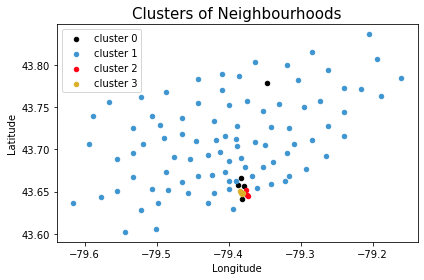

In [520]:
import matplotlib.pyplot as plt
for lab in  np.sort(df_cat['labels'].unique()):
    df_plot = df_cat[df_cat['labels']==lab]
    plt.scatter(df_plot['longitude'],df_plot['latitude'],c=colors_list[lab],s=20,label='cluster '+str(lab))
    
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clusters of Neighbourhoods', fontsize=15)
plt.tight_layout()
plt.savefig('clusters_of_neighbourhood.png')
plt.show()

Plotting the Map

In [517]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [519]:
import random
from IPython.core.display import display, HTML

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for (lat, lng, borough, neighborhood,lab,col) in zip(df_cat['latitude'], df_cat['longitude'], df_cat['borough'], df_cat['neighbourhood'], df_cat['labels'], df_cat['color']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=col,
        fill=True,
        fill_color=col,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

file = 'map.html'

map_toronto.save(file)
display(HTML('<a href="'+file+ '" target="_blank">Click here to see the map.</a>'))

map_toronto